### Hawai'i 2022 General PBER Annotated file
I annotated this more than usual to illustrate my steps. A clean version of my code is also available and titled "AMR_HIG22_Clean"

- #TODO: Automate Vote Total Checks
- #TODO : Fix Multilevel index before JER merge
- #TODO : Change order of columns for each race to descending vote totals


### Sources
- [Hawaii Election results file from MEDSL](https://github.com/MEDSL/2022-elections-official/blob/main/individual_states/2022-hi-local-precinct-general.zip)
- [Hawaii Precinct boundaries](https://geoportal.hawaii.gov/datasets/HiStateGIS::election-precincts/about)
- [State Office of Elections Certified Report Summaries](https://elections.hawaii.gov/election-results/)
- [State Office of Elections Certified Precinct Detail Report](https://elections.hawaii.gov/wp-content/results/precinct.pdf)

In [57]:
# load packages
import numpy as np
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', None) #see all columns of dataframe

In [58]:
# Load in files
gdf = gpd.read_file('HISHP/Election_Precincts.shp')
er = pd.read_csv('HI-cleaned.csv')

In [59]:
# check both dataframes for number of unique precincts and unique precinct ID for later merging
#er.precinct.nunique() # 236 
#gdf.dp.nunique() # 248

In [60]:
# CHECK
#er.precinct.head(1) == gdf.dp.head(1)
#gdf.dp.head()
#gdf.dp.dtype

#### summary
- 12 More precincts in shapefile than in election returns data frame, will need to look into 12 'nonvoting' areas in shapefile
- unique precinct id present in same format in both dfs for later merging

### Preparing Shapefile for merging
Referenced [Metadata for shapefile](https://files.hawaii.gov/dbedt/op/gis/data/precincts.pdf)

#### summary

- Converted districts 18-05 and 42-01 from multiple geographies to multipolygons
- subset df to columns required in final merged df

In [61]:
# CHECK
#gdf.crs

In [62]:
gdf.columns

Index(['objectid', 'dp', 'dpnum', 'dptype', 'county', 'zeropop', 'ballottype',
       'us_house', 'state_hous', 'state_sena', 'county_cou', 'st_areasha',
       'st_perimet', 'geometry'],
      dtype='object')

In [63]:
# check # of zero pop precincts
gdf[['dptype']].value_counts() #239, still 3 more than er df

dptype 
VBMO       239
ZEROPOP     11
dtype: int64

In [64]:
gdf.shape # gdf has 250 rows, but 248 unique precincts

(250, 14)

In [65]:
# gdf['ballottype'].unique().size #some precincts have same ballot type, precincts smaller than county council districts

In [66]:
# look for duplicates
#gdf['objectid'].nunique() #250
gdf['dp'].nunique() #248

248

In [67]:
# filtering duplicated rows
gdf[gdf.duplicated(subset='dp', keep=False)]

,objectid,dp,dpnum,dptype,county,zeropop,ballottype,us_house,state_hous,state_sena,county_cou,st_areasha,st_perimet,geometry
246,247,42-01,4201,VBMO,OAHU,None,CD1-H42-S20-CC9,CD1,H42,S20,CC9,9.219847e+04,1370.015977,"POLYGON ((-158.03044 21.33709, -158.03090 21.3..."
247,248,42-01,4201,VBMO,OAHU,None,CD1-H42-S20-CC9,CD1,H42,S20,CC9,2.152954e+05,2002.045649,"POLYGON ((-158.02814 21.34041, -158.02829 21.3..."
248,249,18-05,1805,VBMO,OAHU,None,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.572862e+05,2852.785704,"POLYGON ((-157.71873 21.28422, -157.71864 21.2..."
249,250,18-05,1805,VBMO,OAHU,None,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.780304e+06,11075.929342,"POLYGON ((-157.70717 21.31775, -157.70638 21.3..."


noticing that for each pair, every column seems to be duplicated exactly, except columns pertaining to geometry.

<AxesSubplot:>

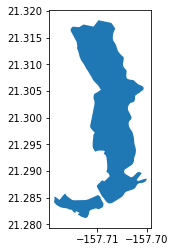

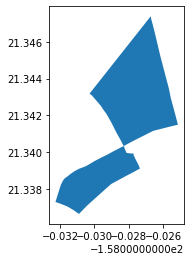

In [68]:
# look at geometries of precinct 18-05, and 42-01
gdf.iloc[[-1,-2]].plot()
gdf.iloc[[-3,-4]].plot()

For each pair, the two geometries seem to comprise one non-contiguous precinct. Looked at all four of these geometries in QGIS with OSM to confirm they are two precincts.

In [69]:
#check before changing df
len(gdf.dissolve(by= 'dp'))

248

In [70]:
gdf = gdf.dissolve(by= 'dp').reset_index()

In [71]:
gdf.head()

,dp,geometry,objectid,dpnum,dptype,county,zeropop,ballottype,us_house,state_hous,state_sena,county_cou,st_areasha,st_perimet
0,01-01,"POLYGON ((-155.69865 20.18589, -155.69855 20.1...",1,101,VBMO,HAWAII,None,CD2-H01-S04-CC1,CD2,H01,S04,CC1,9.949400e+08,243835.454121
1,01-02,"POLYGON ((-155.08329 19.85094, -155.08346 19.8...",2,102,VBMO,HAWAII,None,CD2-H01-S01-CC1,CD2,H01,S01,CC1,1.996375e+08,90596.525487
2,01-03,"POLYGON ((-155.33399 19.78996, -155.33385 19.7...",3,103,VBMO,HAWAII,None,CD2-H01-S01-CC2,CD2,H01,S01,CC2,4.157142e+08,96097.575789
3,01-04,"POLYGON ((-155.43905 19.90430, -155.43883 19.9...",4,104,ZEROPOP,HAWAII,yes,CD2-H01-S04-CC2,CD2,H01,S04,CC2,4.202857e+08,100538.651270
4,02-01,"POLYGON ((-155.08683 19.72785, -155.08679 19.7...",5,201,VBMO,HAWAII,None,CD2-H02-S01-CC2,CD2,H02,S01,CC2,1.954235e+07,28533.769583


In [72]:
#check # of populated unique precincts in shapefile
gdf['dp'].nunique() - int(gdf['zeropop'].value_counts())

237

Shapefile still has 1 more 'populated' precinct than the election returns

In [73]:
#more investigating
gdf.columns

Index(['dp', 'geometry', 'objectid', 'dpnum', 'dptype', 'county', 'zeropop',
       'ballottype', 'us_house', 'state_hous', 'state_sena', 'county_cou',
       'st_areasha', 'st_perimet'],
      dtype='object')

In [74]:
gdf.county.value_counts() #good to know for later, # of precincts in each county in this shapefile, and # and name of counties

OAHU      154
HAWAII     42
MAUI       36
KAUAI      16
Name: county, dtype: int64

In [75]:
#desperation searching for anomalous final precinct
#gdf.county_cou.nunique()
#gdf.ballottype.value_counts()

Looked at previous [PBER files on RDH github](https://github.com/nonpartisan-redistricting-datahub/pber_collection) to see column conventions

1. PRECINCT   County precinct identifier
2. SLDL_DIST  State House District
3. SLDU_DIST  State Senate District  

In [76]:
#subset gdf for merging
gdf_sub = gdf[['dp', 'county', 'us_house', 'state_hous', 'state_sena','geometry']].copy()

In [77]:
#rename columns
cols = ['gdfPRECINCT', 'gdfCOUNTY', 'gdfUSHOUSE', 'gdfSLDL', 'gdfSLDU', 'geometry']
gdf_sub.columns = cols
gdf_sub.head(2)

,gdfPRECINCT,gdfCOUNTY,gdfUSHOUSE,gdfSLDL,gdfSLDU,geometry
0,01-01,HAWAII,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69855 20.1..."
1,01-02,HAWAII,CD2,H01,S01,"POLYGON ((-155.08329 19.85094, -155.08346 19.8..."


In [79]:
gdf_sub['gdfSLDL'] = gdf_sub['gdfSLDL'].apply(lambda x: str(x)[1:])
gdf_sub['gdfSLDU'] = gdf_sub['gdfSLDU'].apply(lambda x: str(x)[1:])
gdf_sub['gdfUSHOUSE'] = gdf_sub['gdfUSHOUSE'].apply(lambda x: str(x)[2:])

In [80]:
# CHECK
gdf_sub.head(2)

,gdfPRECINCT,gdfCOUNTY,gdfUSHOUSE,gdfSLDL,gdfSLDU,geometry
0,01-01,HAWAII,2,01,04,"POLYGON ((-155.69865 20.18589, -155.69855 20.1..."
1,01-02,HAWAII,2,01,01,"POLYGON ((-155.08329 19.85094, -155.08346 19.8..."


### Preparing Elections Returns for merging

#### summary

- subset to statewide offices, or offices pertaining to a state-wide governing body
- Modified to VEST naming conventions (with further modifications to ensure under 10 letter naming convention for offices with contests in districts)
- subset df to columns required in final merged df
- created df for readme key

In [93]:
#er.head()
#er.shape()
#er.isnull().sum()

In [94]:
# Checck Write In
er.writein.value_counts()

False    16555
Name: writein, dtype: int64

In [95]:
#check how many unique precincts
er['precinct'].nunique()

236

In [96]:
er.office.unique()

array(['US SENATE', 'US HOUSE', 'GOVERNOR', 'STATE SENATOR',
       'HAWAII RESIDENT TRUSTEE VACANCY', 'AT-LARGE TRUSTEE',
       "1 HAWAI'I: MEMBERSHIP FOR THE BOARD OF ETHICS",
       "2 HAWAI'I: EXPANDING THE DUTIES OF THE COUNTY AUDITOR",
       "3 HAWAI'I: ESTABLISHING A YOUTH COMMISSION", 'COUNCILMEMBER',
       'STATE HOUSE', 'MAYOR', 'COUNCILMEMBER (EAST MAUI)',
       'COUNCILMEMBER (WEST MAUI)',
       'COUNCILMEMBER (WAILUKU-WAIHEE-WAIKAPU)',
       'COUNCILMEMBER (KAHULUI)', 'COUNCILMEMBER (SOUTH MAUI)',
       'COUNCILMEMBER (MAKAWAO-HAIKU-PAIA)', 'COUNCILMEMBER (UPCOUNTRY)',
       'COUNCILMEMBER (LANAI)', 'COUNCILMEMBER (MOLOKAI)',
       'MAUI COMMISSION PROPOSAL 1: CREATE A SEPARATE HOUSING DEPARTMENT DEDICATED TO AFFORDABLE HOUSING; INCLUDING AN ADVISORY BOARD AND HAWAIIAN HOME LANDS LIAISON',
       "MAUI COMMISSION PROPOSAL 2: DEPARTMENT OF 'OIWI RESOURCES",
       'MAUI COMMISSION PROPOSAL 3: ETHICS AND FINANCIAL DISCLOSURES',
       'MAUI COMMISSION PROPOSAL 4: PL

Checked [Ballotpedia](https://ballotpedia.org/Hawaii_state_executive_official_elections,_2022) for statewide races, and races pertaining to a state-wide governing body. There are 7 types of offices that fit this criteria.

    - US Senate
    - US House
    - Governor/Lt Gov
    - State Senator
    - State House
    - Office of Hawaiian Affairs At Large Trustee
    - Office of Hawaiian Affairs Resident Trustee

    - charter questions are COUNTY wide
    - councilmembers are also COUNTY wide

In [97]:
# subset df to rows pertaining to offices of interest
office_list = ['US SENATE', 'US HOUSE', 'GOVERNOR', 'STATE SENATOR', 'STATE HOUSE', 'AT-LARGE TRUSTEE', 'HAWAII RESIDENT TRUSTEE VACANCY']
er_sub = er[er['office'].isin(office_list)]

In [98]:
# CHECK, looking for 7 types of races
er_sub.office.value_counts().nunique()

7

In [99]:
er_sub.head(2)

,precinct,district,office,writein,party_detailed,party_simplified,candidate,dataverse,mode,votes,...,state_fips,state_cen,state_ic,date,jurisdiction_fips,county_name,county_fips,readme_check,magnitude,special
0,01-01,NaN,US SENATE,False,LIBERTARIAN,LIBERTARIAN,FEENA M BONOAN,SENATE,MAIL IN,35,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False
1,01-01,NaN,US SENATE,False,ALOHA AINA PARTY,OTHER,DAN DECKER,SENATE,MAIL IN,19,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False


In [100]:
#subset columns
er_sub = er_sub[['precinct', 'office', 'party_detailed', 'candidate', 'mode', 'votes']]

In [101]:
er_sub.head()

,precinct,office,party_detailed,candidate,mode,votes
0,01-01,US SENATE,LIBERTARIAN,FEENA M BONOAN,MAIL IN,35
1,01-01,US SENATE,ALOHA AINA PARTY,DAN DECKER,MAIL IN,19
2,01-01,US SENATE,REPUBLICAN,BOB MCDERMOTT,MAIL IN,609
3,01-01,US SENATE,GREEN,EMMA JANE A POHLMAN,MAIL IN,29
4,01-01,US SENATE,DEMOCRAT,BRIAN SCHATZ,MAIL IN,2521


Adapting VEST field naming convention, these are the office codes
##### (modified for contests with districts, to fit GIS 10 character limit)

- USS - U.S. Senate
- CD# - U.S. Congress District
- GOV - Governor/Lieutenant Governor
- SL##  - State Legislative Lower District ##
- SU##  - State Legislative Upper District ##
- ALT - Office of Hawaiian Affairs, At Large Trustee
- RTH - Office of Hawaiian Affairs, Resident Trustee for Hawaii (H - Hawaii, M - Maui, O - Oahu) **general election only occured for county of Hawaii

In [102]:
office_list = list(er_sub['office'].unique())
office_list

['US SENATE',
 'US HOUSE',
 'GOVERNOR',
 'STATE SENATOR',
 'HAWAII RESIDENT TRUSTEE VACANCY',
 'AT-LARGE TRUSTEE',
 'STATE HOUSE']

In [103]:
#rename offices
new_office_list = ['G22USS', 'G22CD', 'G22GOV', 'GSU', 'G22RTH', 'G22ALT', 'GSL']
er_sub['race'] = er_sub['office']
er_sub['race'].replace(office_list, new_office_list, inplace=True)

In [104]:
er_sub.head(2)

,precinct,office,party_detailed,candidate,mode,votes,race
0,01-01,US SENATE,LIBERTARIAN,FEENA M BONOAN,MAIL IN,35,G22USS
1,01-01,US SENATE,ALOHA AINA PARTY,DAN DECKER,MAIL IN,19,G22USS


Will need State Senate, State House, and US congressional districts to complete naming convention. Will append from gdf.

In [ ]:
#merge subset of gdf to append columns for districts
er_sub = pd.merge(er_sub,gdf_sub[['PRECINCT', 'USHOUSE', 'SLDL', 'SLDU']],left_on='precinct', right_on = 'PRECINCT', how= 'left', indicator = True)

In [ ]:
#check indicator to see if merge was successful
er_sub._merge.value_counts()

In [ ]:
er_sub.head(2)

In [ ]:
#replace 'CD#' with Congressional District
er_sub.loc[er_sub.race=='G22CD', 'race'] =  er_sub['race'] + er_sub['USHOUSE']
#replace 'SU#' with SLDU
er_sub.loc[er_sub.race=='GSU', 'race'] = er_sub['race'] + er_sub['SLDU']
#replace 'SL#' with SLDL
er_sub.loc[er_sub.race=='GSL', 'race'] = er_sub.race + er_sub['SLDL']

In [ ]:
#check
er_sub.race.value_counts().nunique()

Before modifying party column, checking for how non-partisan or unregistered is noted

In [ ]:
er_sub['party_detailed'].value_counts()

In [ ]:
er_sub['party_detailed'].isnull().sum()

#TODO: Double check HI state metadata for what null party column means

In [ ]:
#change null to NONPARTISAN/UNREGISTERED
er_sub['party_detailed'].fillna('NONPARTISAN/UNREGISTERED', inplace = True)

In [ ]:
#append 1 letter party to make VEST column
er_sub['VEST'] = er_sub['race'] + er_sub['party_detailed'].apply(lambda x : str(x)[0])
#create 3 letter party for readme
er_sub['party_detailed'] = er_sub['party_detailed'].apply(lambda x: str(x)[:3].upper())

Before modifying candidate names for README, double check for write-in candidates

In [ ]:
('WRITE IN' in er_sub['candidate'].unique())

In [ ]:
#double check visually

#er_sub['candidate'].value_counts()

In [ ]:
#append 3 letter last name to 'VEST' column
er_sub['VEST'] = er_sub['VEST'] + er_sub['candidate'].apply(lambda x: str(x).split()[-1][:3])

In [ ]:
#create candidate column for readme
er_sub['candidate'] = er_sub['candidate'].apply(lambda x: str(x).split()[-1] + ', ' + ' '.join(str(x).split()[:-1]))

In [ ]:
#add 3 letter party
er_sub['candidate'] += ' - ' + er_sub['party_detailed']

In [ ]:
er_sub.head()

In [ ]:
#check party value_counts
er_sub['party_detailed'].value_counts()

In [ ]:
#drop extra columns
er_sub.drop(labels = ['PRECINCT', 'party_detailed','USHOUSE', 'SLDL', 'SLDU', '_merge'], axis = 1, inplace = True)

In [ ]:
er_sub.head(2)

In [ ]:
#subset df for readme creation
rm = er_sub[['office', 'race', 'VEST', 'candidate']].copy().drop_duplicates(keep = 'first')

In [ ]:
rm.shape #157 candidates

### Pivoting Elections Return Data + Checking Vote Totals

#### summary

- 2 vote total summaries for 2 candidates for US Senate, Bonoan and Decker


In [ ]:
er_pivot = er_sub.pivot_table(index = ['precinct'],
                         columns = ['office', 'race', 'candidate'],
                        values = ['votes'],
                         aggfunc = 'sum',
                              fill_value=0,
                             margins = True)#.reset_index()

In [ ]:
er_pivot.shape #looking for 236

In [ ]:
er_pivot.tail()

In [ ]:
er_pivot.columns = er_pivot.columns.droplevel(level =0)

In [ ]:
er_pivot.columns[1]

Manually check race vote totals against [State PDF Summary](https://elections.hawaii.gov/wp-content/results/histatewide.pdf)

### Break up office list but sublists of races in each office


In [ ]:
for item in (office_list):
    print('****' + item + '*****')
    print(er_pivot[[(item)]].sum().astype(int).sort_index(level = 2))

#TODO/Anomalies
- US Senate
    - Bonoan 4876 instead of 4915
    - Bonoan needs to change to LIB
    - Decker 2189 instead of 2208
    - Pohlman to G
    - Schatz to D
- US HOUSE
    - Case to D
    - Tokuda to D
    - Akana to R
- GOV/LT GOV
    - change naming convention to be gov/ltgov
    - aionia to R
    - green to D
- STATE SENATOR
    - INOUYE to D
    - Tupai to R
    - Buenaventura to D
    - Fogel to L
    - Osborn to R
    - Richards to D
    - Tancheff to R
    - Mckelvey to D
    - Walter to R
    - Decoite to D
    - Mckay to R
    
#### TODO : Fix Party Assignments for all candidates mislabeled AA

In [ ]:
#Investigate anomalies in Senate undercounts for Bonoan and Decker
bonoan = 4915-4876
print(bonoan)
decker = 2208-2189
print(decker)

Since these are small numbers, I will first check in the Mail-In votes

### Merge Precincts Shapefile

In [ ]:
er_pivot.columns = er_pivot.columns.map('_'.join)

In [ ]:
er_pivot.head()

In [ ]:
er_pivot.columns[1]
#= gdf_sub['SLDL'].apply(lambda x: str(x)[1:])

In [ ]:
er_pivot.head()

In [ ]:
#join shapefile
#jer = pd.merge(er_pivot,gdf_sub,on='PRECINCT', how= 'right', indicator = True)
#jer._merge.value_counts()

Noticing that all precincts successfully merged, including the 12 precincts that had no votes/election returns.

In [ ]:
jer.columns

### Final Checks + Export Joined Data Set

In [ ]:
#TODO Check to see if length of cols is 10 characters or less
#[i for i in jer.columns if len(i)>10]

## TESTING

In [ ]:
er_sub.head()

In [ ]:
office_list

In [ ]:
for i in office_list:
    i

In [ ]:
def get_races(office_list, df):
    for i in office_list:
        i_lst = []
        races_list = sorted(list(df[df.office == i]['race'].unique()))
        for ele in races_list:
        

In [ ]:
races_list = sorted(list(er_sub[er_sub.office == 'STATE SENATOR']['race'].unique()))

In [ ]:
print(races_list)

In [ ]:
for ele in races_list:
    

In [ ]:
print(temp)

In [ ]:
er_pivot.head()